# 本章要解决的问题

本章将介绍如何使用Drake的Diagram机制来组合和管理多个动力学系统，包括：
- 如何构建和可视化系统的Diagram结构
- Diagram与子系统的关系及其Context的操作方法
- Diagram的嵌套与端口导出
- Diagram的标量类型支持与进阶用法

通过本章学习，你将能够灵活地用Diagram组织复杂的系统结构。

# 使用图（Diagrams）进行系统建模
关于如何运行本教程笔记本，请参见 [索引](./index.ipynb)。

## 概述

[建模动力系统](./dynamical_systems.ipynb) 教程对Drake的系统框架进行了基础介绍，包括如何将多个系统组装成一个 `Diagram`。在本笔记本中，我们将更全面地介绍如何使用Diagram。

方块图（Block diagrams）是系统理论和控制中的标准建模抽象。它们为编写描述复杂动力系统的模块化代码提供了强大的抽象能力。

In [1]:
import numpy as np
import pydot
from pydrake.examples import PendulumPlant
from pydrake.systems.controllers import PidController
from pydrake.systems.drawing import plot_system_graphviz
from pydrake.systems.framework import Diagram, DiagramBuilder, LeafSystem
from pydrake.systems.primitives import AffineSystem, LogVectorOutput

## 构建和可视化你的Diagram

让我们从[入门教程](./1_动态系统建模.ipynb)中的 `Diagram` 示例开始回顾。

/home/lvxiangyu11/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


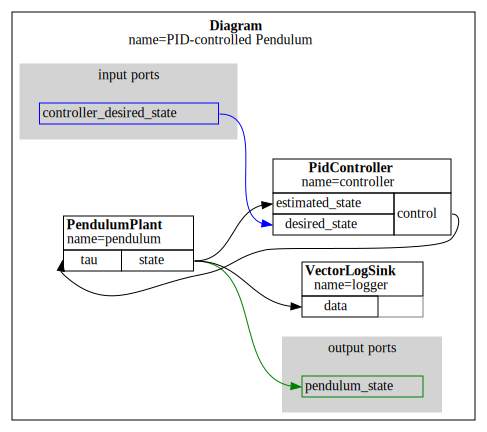

In [2]:
def MakePidControlledPendulum():
    # 使用DiagramBuilder添加和连接子系统。
    builder = DiagramBuilder()

    # 首先添加摆系统。
    pendulum = builder.AddNamedSystem("pendulum", PendulumPlant())

    # 添加PID控制器。
    controller = builder.AddNamedSystem("controller",
                                        PidController(kp=[10.], ki=[1.], kd=[1.]))

    # 现在将控制器与摆系统连接。
    builder.Connect(pendulum.get_state_output_port(),
                    controller.get_input_port_estimated_state())
    builder.Connect(controller.get_output_port_control(), pendulum.get_input_port())

    # 将controller的desired_state输入端口导出为diagram的输入端口。
    builder.ExportInput(controller.get_input_port_desired_state())
    # 将pendulum的状态输出端口导出为diagram的输出端口。
    builder.ExportOutput(pendulum.get_state_output_port())

    # 记录摆系统的状态。
    logger = LogVectorOutput(pendulum.get_state_output_port(), builder)
    logger.set_name("logger")

    pid_controlled_pendulum = builder.Build()
    pid_controlled_pendulum.set_name("PID-controlled Pendulum")

    return pid_controlled_pendulum, pendulum

pid_controlled_pendulum, pendulum = MakePidControlledPendulum()

# 可视化diagram。
plot_system_graphviz(pid_controlled_pendulum, max_depth=2)

### 一个System只能被添加到一个DiagramBuilder中

需要注意的是，当你将一个系统添加到builder时，builder会拥有该系统的所有权。你不能将同一个系统添加到另一个builder中。目前，Drake会报告一个关于C++对象所有权的通用错误：

In [3]:
second_builder = DiagramBuilder()

try:
    # 尝试将同一个pendulum系统添加到另一个builder，会报错。
    second_builder.AddSystem(pendulum)
except RuntimeError as err:
    print(err)

这个概念很简单，但在jupyter笔记本中很容易遇到。如果你在一个单元格中定义了一个系统，在另一个单元格中将其添加到builder，然后连续两次运行第二个单元格，就会报错。因此，推荐的做法是立即（在同一个单元格中）构建系统并添加到builder，或者像上面那样用函数来构建系统。

## 嵌套Diagram

Diagram本身也是System，可以作为子系统实现模块化和封装。假设我们想在另一个场景中复用同样的PID控制摆系统，但希望将坐标系平移$\pi$。我们可以通过在受控摆系统外部添加更多系统来实现。

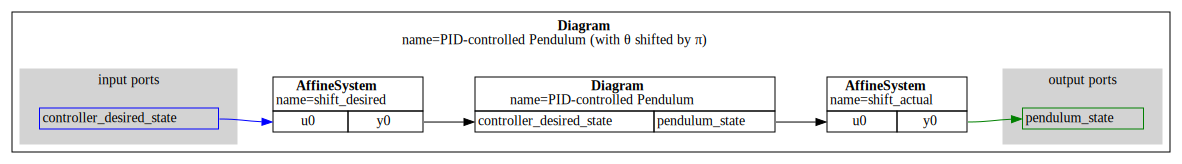

In [4]:
builder = DiagramBuilder()

# 这里我们再次构建PID控制的摆系统，以避免C++所有权问题。
pid_controlled_pendulum, pendulum = MakePidControlledPendulum()
builder.AddSystem(pid_controlled_pendulum)

# 用系统 y = u + [pi;0] 实现对期望theta的平移。
shift_desired = builder.AddNamedSystem(
    "shift_desired", AffineSystem(D=np.eye(2), y0=[np.pi, 0]))
builder.ExportInput(shift_desired.get_input_port(),
                    "controller_desired_state")

# 将shift的输出连接到子diagram导出的输入端口。
builder.Connect(shift_desired.get_output_port(),
                pid_controlled_pendulum.get_input_port())

# 用系统 y = u + [-pi;0] 实现对实际theta的平移。
shift_actual = builder.AddNamedSystem(
    "shift_actual", AffineSystem(D=np.eye(2), y0=[-np.pi, 0]))
builder.Connect(pid_controlled_pendulum.get_output_port(),
                shift_actual.get_input_port())
builder.ExportOutput(shift_actual.get_output_port(), "pendulum_state")

diagram = builder.Build()
diagram.set_name("PID-controlled Pendulum (with θ shifted by π)")

# 可视化diagram（max depth=1）
plot_system_graphviz(diagram, max_depth=1)

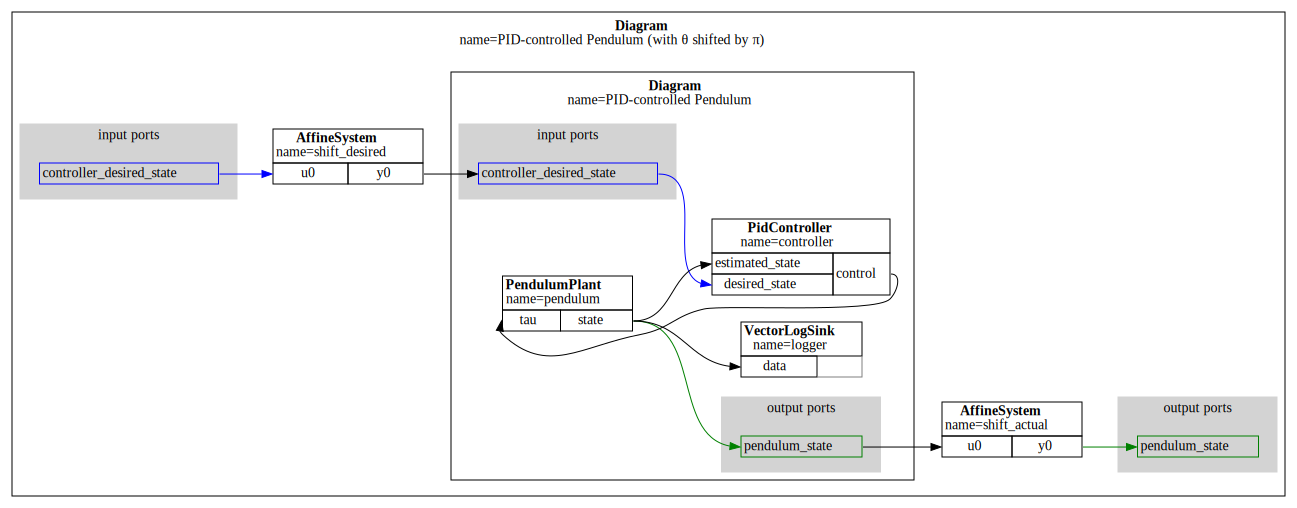

In [5]:
# 可视化diagram（max depth=2）
plot_system_graphviz(diagram, max_depth=2)

## 子系统与Context

现在我们有了一个`Diagram`，可以直接操作它的`Context`。但如果依赖于diagram的`Context`中状态变量的顺序（比如你添加了更多系统，顺序就会变），会很脆弱。而且，单独的子系统可能还会提供一些便于操作其`Context`的方法。

通过`DiagramBuilder::AddSystem()`/`AddNamedSystem()`返回的指针依然是子系统的有效指针，可以直接使用。此外，`Diagram`还提供了检索其包含的子系统指针的方法。

In [6]:
# 验证通过名字获取的子系统和原始指针一致
assert(pid_controlled_pendulum.GetSubsystemByName("pendulum") == pendulum)

更有趣的是子系统的`Context`。你应该理解diagram的`Context`其实就是子系统`Context`的有序集合。你可以直接访问这些子系统的`Context`，最常用的是[`GetMyContextFromRoot()`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_system.html#ae7fa91d2b2102457ced3361207724e52)。注意，由于diagram本身也可以作为其他diagram的子系统，这个方法会递归地获取正确的子`Context`。

在本例中，`Context`的嵌套结构如下：

```

  PID-controlled Pendulum (with θ shifted by π) Context (of a Diagram)

    ↳ PID-controlled Pendulum Context (of a Diagram)

        ↳ pendulum Context

        ↳ controller Context

```

In [7]:
diagram_context = diagram.CreateDefaultContext()
print(diagram_context)

::PID-controlled Pendulum (with θ shifted by π) Context (of a Diagram)
-------------------------------------------------------------------------
3 total continuous states
4 total numeric parameters in 1 groups

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum Context (of a Diagram)
--------------------------------------------------------------------------------------------------
3 total continuous states
4 total numeric parameters in 1 groups

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum::pendulum Context
---------------------------------------------------------------------------------------------
Time: 0
States:
  2 continuous states
    0 0

Parameters:
  1 numeric parameter groups with
     4 parameters
          1  0.5  0.1 9.81

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum::controller Context
-----------------------------------------------------------------------------------------------
Time: 0
States:

重要的是，通过这种方式从diagram的`Context`获取的子系统`Context`其实就是diagram的`Context`中的一部分。修改子系统`Context`的值会直接改变根`Context`中的值；实际上，这也是推荐的修改方式。

In [8]:
pendulum_context = pendulum.GetMyContextFromRoot(diagram_context)
pendulum_context.SetContinuousState([1.2, 0.5])
# PendulumPlant类为操作其Context提供了一些辅助方法。
pendulum_state = pendulum.get_state(pendulum_context)
print(f"θ = {pendulum_state.theta()}, θ̇ = {pendulum_state.thetadot()}")

θ = 1.2, θ̇ = 0.5


In [9]:
# 可以看到根系统的Context也被更新了。
print(diagram_context)

::PID-controlled Pendulum (with θ shifted by π) Context (of a Diagram)
-------------------------------------------------------------------------
3 total continuous states
4 total numeric parameters in 1 groups

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum Context (of a Diagram)
--------------------------------------------------------------------------------------------------
3 total continuous states
4 total numeric parameters in 1 groups

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum::pendulum Context
---------------------------------------------------------------------------------------------
Time: 0
States:
  2 continuous states
    1.2 0.5

Parameters:
  1 numeric parameter groups with
     4 parameters
          1  0.5  0.1 9.81

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum::controller Context
-----------------------------------------------------------------------------------------------
Time: 0
Sta

总之，`LeafSystem`的`Context`就是一个包含时间、状态、参数和输入的类，可以在几乎所有系统方法中访问。`Diagram`的`Context`也提供了同样的抽象（因为Diagram也是System），但还额外提供了直接操作子系统`Context`的方法。


## 导出输入输出端口

当我们[自定义叶系统](./authoring_leaf_systems.ipynb)时，会声明输入输出端口。在组装`Diagram`时，我们将子系统的输入输出端口导出为Diagram的输入输出端口。

不要直接访问子系统的端口。

一个常见错误是试图直接连接到子系统的输入/输出端口。以我们的嵌套Diagram为例：

In [10]:
builder = DiagramBuilder()

pid_controlled_pendulum, pendulum = MakePidControlledPendulum()
builder.AddSystem(pid_controlled_pendulum)

# 用系统 y = u + [pi;0] 实现对期望theta的平移。
shift_desired = builder.AddNamedSystem(
    "shift_desired", AffineSystem(D=np.eye(2), y0=[np.pi, 0]))

# ** 错误示例 ** 这样做会报错，但会给出有用的提示信息。
controller = pid_controlled_pendulum.GetSubsystemByName("controller")
try:
    builder.Connect(shift_desired.get_output_port(),
                    controller.get_input_port_desired_state())
except RuntimeError as err:
    print(err)

DiagramBuilder: System 'controller' has not been registered to this DiagramBuilder using AddSystem nor AddNamedSystem.

The systems currently registered to this builder are: 'PID-controlled Pendulum', 'shift_desired'.

If 'controller' was registered as a subsystem to one of these, you must export the input or output port using ExportInput/ExportOutput and then connect to the exported port.


如上例所示，正确的做法是将shift的输出连接到`pid_controlled_pendulum`子diagram导出的输入端口。

## Diagram也是System

`Diagram`实现了`System`类接口。为此，它会分发到子系统的实现并收集结果。下面是一个小例子，展示了它如何处理时间导数和publish事件，实际上所有`System`方法都会类似地工作。

In [11]:
class MyLeafSystem(LeafSystem):
    def __init__(self):
        super().__init__()

        self.DeclareContinuousState(1)
        self.DeclareForcedPublishEvent(self.Publish)
        self.DeclarePeriodicPublishEvent(period_sec=1,
                                         offset_sec=0,
                                         publish=self.Publish)

    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().GetAtIndex(0)
        print(f"{self.get_name()}: DoCalcTimeDerivatives()")
        derivatives.get_mutable_vector().SetAtIndex(0, -x)

    def Publish(self, context):
        print(f"{self.get_name()}: Publish()")

builder = DiagramBuilder()
builder.AddNamedSystem("system1", MyLeafSystem())
builder.AddNamedSystem("system2", MyLeafSystem())
diagram = builder.Build()

context = diagram.CreateDefaultContext()

# 计算diagram的时间导数时，会计算所有子系统的时间导数。
print("diagram.EvalTimeDerivatives()")
diagram.EvalTimeDerivatives(context)

# Diagram的ForcedPublish会调用所有子系统的ForcedPublish。
print("diagram.ForcedPublish()")
diagram.ForcedPublish(context)

diagram.EvalTimeDerivatives()
system1: DoCalcTimeDerivatives()
system2: DoCalcTimeDerivatives()
diagram.ForcedPublish()
system1: Publish()
system2: Publish()


## Diagram与标量类型（double, AutoDiffXd, symbolic::Expression）

Diagram支持多种标量类型，并且如果所有子系统都支持标量类型，可以进行[标量类型转换](https://drake.mit.edu/doxygen_cxx/group__system__scalar__conversion.html)。最常见的做法是先用默认标量类型构建Diagram，然后用`ToAutoDiffXd()`和/或`ToSymbolic()`进行转换。

In [12]:
builder = DiagramBuilder()
# AffineSystem是一个支持所有标量类型和标量转换的基础系统。
builder.AddSystem(AffineSystem(y0=[2, 3]))
builder.AddSystem(AffineSystem(D=np.eye(2)))
diagram = builder.Build()

diagram_autodiff = diagram.ToAutoDiffXd()
diagram_symbolic = diagram.ToSymbolic()

In [13]:
builder = DiagramBuilder()
# 上面定义的MyLeafSystem没有实现标量类型支持，因此生成的Diagram也不支持。
builder.AddSystem(MyLeafSystem())
diagram = builder.Build()

print("调用 ToAutoDiffXd()")
try:
    diagram_autodiff = diagram.ToAutoDiffXd()
except RuntimeError as err:
    print(err)

print("\n调用 ToSymbolic()")
try:
    diagram_symbolic = diagram.ToSymbolic()
except RuntimeError as err:
    print(err)

调用 ToAutoDiffXd()
System ::_ of type drake::systems::Diagram<double> does not support scalar conversion to type drake::AutoDiffXd (because System ::_::__main__.MyLeafSystem@00005615ce990470 of type __main__.MyLeafSystem does not support scalar conversion to type drake::AutoDiffXd)

调用 ToSymbolic()
System ::_ of type drake::systems::Diagram<double> does not support scalar conversion to type drake::symbolic::Expression (because System ::_::__main__.MyLeafSystem@00005615ce990470 of type __main__.MyLeafSystem does not support scalar conversion to type drake::symbolic::Expression)


关于如何为自定义叶系统添加标量类型支持，请参见[自定义叶系统](./authoring_leaf_systems.ipynb)教程。

# （进阶）继承Diagram类

大多数情况下，使用`DiagramBuilder()`构建diagram就足够了。但有时如果你想为diagram本身提供更多方法或成员变量，可以自定义一个继承自`Diagram`的类。

In [14]:
class CustomDiagram(Diagram):

    def __init__(self):
        Diagram.__init__(self)
        builder = DiagramBuilder()
        builder = DiagramBuilder()
        self.system1 = builder.AddNamedSystem("system1", MyLeafSystem())
        self.system2 = builder.AddNamedSystem("system2", MyLeafSystem())
        # 这里不调用builder.Build()，而是调用
        builder.BuildInto(self)

    def get_system1(self):
        return self.system1
    
    def get_system2(self):
        return self.system2
    
diagram = CustomDiagram()
context = diagram.CreateDefaultContext()
print(context)

::_ Context (of a Diagram)
---------------------------
2 total continuous states

::_::system1 Context
---------------------
Time: 0
States:
  1 continuous states
    0


::_::system2 Context
---------------------
Time: 0
States:
  1 continuous states
    0




Drake中的一个例子是`RobotDiagram`，它就是一个自动包含`MultibodyPlant`和`SceneGraph`的`Diagram`，并提供了便捷的方法来获取它们。